In [1]:
import os
import re
import pyhf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import interpolate

## CLs method

In [2]:
def get_upperlimit_info(bkg_path, sig_path, n_bin=20, hist_range=[0, 1], L=139, cross_section={'signal':1, 'background':1}):
    # Background    
    # results after selection
    cross_section_b = cross_section['background'] 
    cross_section_s = cross_section['signal']
    results_b = np.load(bkg_path, allow_pickle=True)
    N_bkg, _ = np.histogram(results_b, bins=n_bin, range=hist_range, weights=np.ones_like(results_b) / len(results_b) * L * cross_section_b)

    results_s = np.load(sig_path, allow_pickle=True)
    N_sig, _ = np.histogram(results_s, bins=n_bin, range=hist_range, weights=np.ones_like(results_s) / len(results_s) * L * cross_section_s)
    
    
    model = pyhf.simplemodels.uncorrelated_background(
        signal=list(N_sig), bkg=list(N_bkg), bkg_uncertainty=[0]*n_bin
    )

    poi_values = np.linspace(0.5, 10, 100)
    obs_limit, exp_limits, (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        list(N_bkg) + model.config.auxdata, model, poi_values, level=0.05, return_results=True
    )

        
    results = {
        # 'mass': masses,
        'Expected limits': exp_limits,
        'Cross section: bkg': cross_section_b,
        'Cross section: sig': cross_section_s,
    }
    
    return results

def get_cross_section_from_MG5(banner_path):
    # retuns the cross section in fb
    with open(banner_path, 'r') as f:
        lines = f.readlines()
        #  Integrated weight (pb)  :       0.080199
    for line in lines:
        match = re.match(r'#  Integrated weight \(pb\)  :\s+(\d+\.\d+)', line)
        if match:
            integrated_weight = float(match.group(1)) * 1000
            return integrated_weight

In [3]:
n_bin = 20
hist_range = [0, 1]
L = 126

# DM-CPV

## DNN selection, 1M

In [5]:
bkg_path = f'./Upper_limit/DNN_selection/abs_pairing/bkg-1M.npy'
sig_path = f'./Upper_limit/DNN_selection/abs_pairing/sig-1M.npy'

get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L)

{'Expected limits': [[array(0.8575373),
   array(1.4039716),
   array(2.48065048),
   array(4.48370813),
   array(7.67982305)]]}

In [4]:
bkg_path = f'./Upper_limit/DNN_selection/chi2_pairing/bkg-1M.npy'
sig_path = f'./Upper_limit/DNN_selection/chi2_pairing/sig-1M.npy'

get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L)

{'Expected limits': [[array(0.8585155),
   array(1.40574193),
   array(2.48360171),
   array(4.48850457),
   array(7.68649962)]]}

In [6]:
bkg_path = f'./Upper_limit/DNN_selection/4b_SPANet_pairing/bkg-1M.npy'
sig_path = f'./Upper_limit/DNN_selection/4b_SPANet_pairing/sig-1M.npy'

get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L)

{'Expected limits': [[array(0.85811011),
   array(1.40418804),
   array(2.47942353),
   array(4.47943552),
   array(7.67131921)]]}

## SPANet selection

In [7]:
bkg_path = f'./Upper_limit/SPANet_selection/bkg-1M.npy'
sig_path = f'./Upper_limit/SPANet_selection/sig-1M.npy'

get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L)

{'Expected limits': [[array(0.68689168),
   array(1.17990243),
   array(2.17855228),
   array(4.07619347),
   array(7.15576067)]]}

# TRSM

## 4 mass points mixed: 4b 750k sig + 1M bkg; 6b 12.5k sig + 50k bkg

In [ ]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325)]

In [39]:
results = {}
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing']:
    results[pairing_method] = {}
    for m3, m2 in tqdm(m3_m2_list):
        bkg_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b/bkg-mix_4-750k.npy'
        sig_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}/sig-mix_4-750k.npy'
        
        BR_Hbb = 0.5824
        # load csv
        df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
        pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
        pass_rate_bkg_6b = 0.1 # should be replaced with the actual value
        cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt') 
        cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
        cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

        result = {'Signal cross section': cross_section_s,
                  'Background cross section': cross_section_b,
                  'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
                }    

        results[pairing_method][(m3, m2)] = result

100%|██████████| 4/4 [00:22<00:00,  5.61s/it]


In [45]:
selection = 'SPANet_selection'
results[selection] = {}
for m3, m2 in tqdm(m3_m2_list):
    bkg_path = f'./Upper_limit/{selection}/TRSM/pp6b/bkg-mix_5-250k.npy'
    sig_path = f'./Upper_limit/{selection}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-250k.npy'
    
    BR_Hbb = 0.5824
    # load csv
    df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
    pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
    pass_rate_bkg_6b = 0.1 # should be replaced with the actual value
    cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt') 
    cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
    cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

    result = {'Signal cross section': cross_section_s,
                'Background cross section': cross_section_b,
                'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
            }    

    results[selection][(m3, m2)] = result

100%|██████████| 4/4 [00:22<00:00,  5.60s/it]


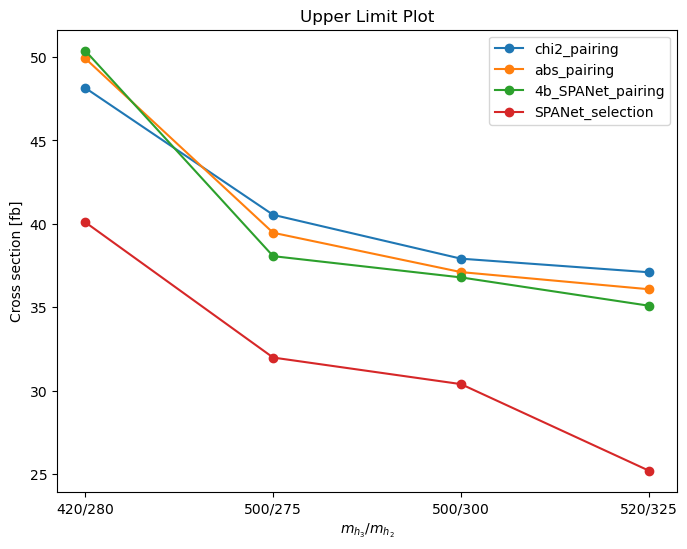

In [46]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325)]
fig, ax = plt.subplots(figsize=(8, 6))
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing', 'SPANet_selection']:
    upper_limits = []
    MG_cross_section = []
    for m3_m2 in m3_m2_list:
        cross_section_s = results[pairing_method][m3_m2]['Signal cross section']
        cross_upper_limit = results[pairing_method][m3_m2]['Upper limit info']['Expected limits'][2] * cross_section_s
        upper_limits.append(cross_upper_limit)

        MG_cross_section.append(cross_section_s)

    m3_m2_label = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
    ax.plot(m3_m2_label, upper_limits, label=f'{pairing_method}', marker='o')

ax.set_xlabel('$m_{h_3}/m_{h_2}$')
ax.set_ylabel('Cross section [fb]')
ax.legend()
plt.title('Upper Limit Plot')
plt.show()

## 5 mass points mixed: 4b 250k sig + 1M bkg; 6b 10k sig + 50k bkg

In [4]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [5]:
results = {}
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing']:
    results[f'DNN_{pairing_method}'] = {}
    for m3, m2 in tqdm(m3_m2_list):
        bkg_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b/bkg-mix_5-250k.npy'
        sig_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-250k.npy'
        
        BR_Hbb = 0.5824
        # load csv
        df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
        pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
        pass_rate_bkg_6b = 0.1 # should be replaced with the actual value
        cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt') 
        cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
        cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

        result = {'Signal cross section': cross_section_s,
                  'Background cross section': cross_section_b,
                  'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
                }    

        results[f'DNN_{pairing_method}'][(m3, m2)] = result

100%|██████████| 5/5 [00:30<00:00,  6.18s/it]


In [6]:
selection = 'SPANet_selection'
results[selection] = {}
for m3, m2 in tqdm(m3_m2_list):
    bkg_path = f'./Upper_limit/{selection}/TRSM/pp6b/bkg-mix_5-250k.npy'
    sig_path = f'./Upper_limit/{selection}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-250k.npy'
    
    BR_Hbb = 0.5824
    # load csv
    df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
    pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
    pass_rate_bkg_6b = 0.1 # should be replaced with the actual value
    cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt') 
    cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
    cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

    result = {'Signal cross section': cross_section_s,
                'Background cross section': cross_section_b,
                'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
            }    

    results[selection][(m3, m2)] = result

100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


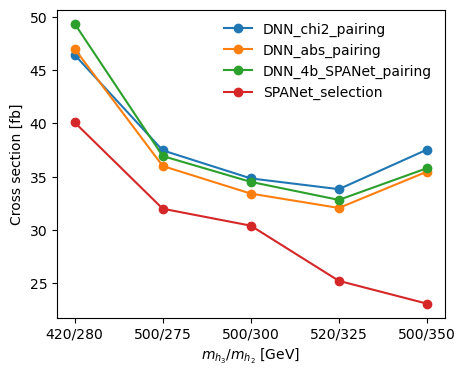

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
for selection_method in ['DNN_chi2_pairing', 'DNN_abs_pairing', 'DNN_4b_SPANet_pairing', 'SPANet_selection']:
    upper_limits = []
    MG_cross_section = []
    for m3_m2 in m3_m2_list:
        cross_section_s = results[selection_method][m3_m2]['Signal cross section']
        cross_upper_limit = results[selection_method][m3_m2]['Upper limit info']['Expected limits'][2] * cross_section_s
        upper_limits.append(cross_upper_limit)

        MG_cross_section.append(cross_section_s)

    m3_m2_label = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
    ax.plot(m3_m2_label, upper_limits, label=f'{selection_method}', marker='o')

ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Cross section [fb]')
ax.legend(frameon=False)

plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-250k.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## 5 mass points mixed: 4b 1M sig + 1M bkg; 6b 10k sig + 50k bkg

In [4]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [5]:
results = {}
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    results[f'DNN_{pairing_method}'] = {}
    for m3, m2 in tqdm(m3_m2_list):
        bkg_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b/bkg-mix_5-1M.npy'
        sig_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-1M.npy'
        
        BR_Hbb = 0.5824
        # load csv
        df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
        pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
        pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
        cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
        cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
        cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

        result = {'Signal cross section': cross_section_s,
                  'Background cross section': cross_section_b,
                  'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
                }    

        results[f'DNN_{pairing_method}'][(m3, m2)] = result

100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


In [6]:
selection = 'SPANet_selection'
results[selection] = {}
for m3, m2 in tqdm(m3_m2_list):
    bkg_path = f'./Upper_limit/{selection}/TRSM/pp6b/bkg-mix_5-1M.npy'
    sig_path = f'./Upper_limit/{selection}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-1M.npy'
    
    BR_Hbb = 0.5824
    # load csv
    df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
    pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
    pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
    cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
    cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
    cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

    result = {'Signal cross section': cross_section_s,
                'Background cross section': cross_section_b,
                'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
            }    

    results[selection][(m3, m2)] = result

100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


In [7]:
ATLAS_upper_limit = {(420, 280): 123.2, (500, 275): 93.6, (500, 300): 86.2, (520, 325): 80.8, (500, 350): 93.6}
ATLAS_cross_section_s = {(420, 280): 58.9, (500, 275): 52.94, (500, 300): 51.68, (520, 325): 43.78, (500, 350): 37.91}
results['ATLAS'] = {}
for m3_m2 in m3_m2_list:
    result = {'Signal cross section': ATLAS_cross_section_s[m3_m2],
              'Background cross section': 1,
              'Upper limit info': {'Expected limits': [1, 1, ATLAS_upper_limit[m3_m2] / ATLAS_cross_section_s[m3_m2], 1, 1]}
            }
    results['ATLAS'][m3_m2] = result

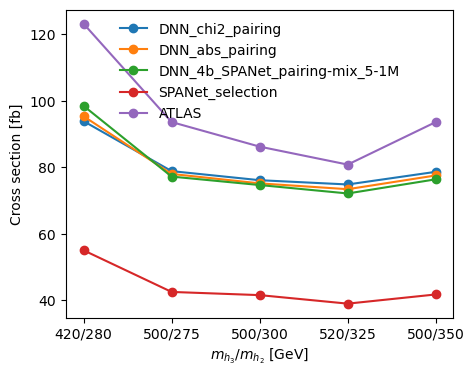

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
for selection_method in ['DNN_chi2_pairing', 'DNN_abs_pairing', 'DNN_4b_SPANet_pairing-mix_5-1M', 'SPANet_selection', 'ATLAS']:
    upper_limits = []
    MG_cross_section = []
    for m3_m2 in m3_m2_list:
        cross_section_s = results[selection_method][m3_m2]['Signal cross section']
        cross_upper_limit = results[selection_method][m3_m2]['Upper limit info']['Expected limits'][2] * cross_section_s
        upper_limits.append(cross_upper_limit)

        MG_cross_section.append(cross_section_s)

    m3_m2_label = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
    ax.plot(m3_m2_label, upper_limits, label=f'{selection_method}', marker='o')

ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Cross section [fb]')
ax.legend(frameon=False)

# plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-1M.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-1M-ATLAS.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## 5 mass points mixed: 4b 1M sig + 1M bkg; 6b 10k sig + 50k bkg, 24 nodes x 3

In [4]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [5]:
results = {}
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    results[f'DNN_{pairing_method}'] = {}
    for m3, m2 in tqdm(m3_m2_list):
        bkg_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b/bkg-mix_5-1M-24_nodes.npy'
        sig_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-1M-24_nodes.npy'
        
        BR_Hbb = 0.5824
        # load csv
        df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
        pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
        pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
        cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
        cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
        cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

        result = {'Signal cross section': cross_section_s,
                  'Background cross section': cross_section_b,
                  'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
                }    

        results[f'DNN_{pairing_method}'][(m3, m2)] = result

100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


In [6]:
selection = 'SPANet_selection'
results[selection] = {}
for m3, m2 in tqdm(m3_m2_list):
    bkg_path = f'./Upper_limit/{selection}/TRSM/pp6b/bkg-mix_5-1M.npy'
    sig_path = f'./Upper_limit/{selection}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-1M.npy'
    
    BR_Hbb = 0.5824
    # load csv
    df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
    pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
    pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
    cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
    cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
    cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

    result = {'Signal cross section': cross_section_s,
                'Background cross section': cross_section_b,
                'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
            }    

    results[selection][(m3, m2)] = result

100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


In [7]:
ATLAS_upper_limit = {(420, 280): 123.2, (500, 275): 93.6, (500, 300): 86.2, (520, 325): 80.8, (500, 350): 93.6}
ATLAS_cross_section_s = {(420, 280): 58.9, (500, 275): 52.94, (500, 300): 51.68, (520, 325): 43.78, (500, 350): 37.91}
results['ATLAS'] = {}
for m3_m2 in m3_m2_list:
    result = {'Signal cross section': ATLAS_cross_section_s[m3_m2],
              'Background cross section': 1,
              'Upper limit info': {'Expected limits': [1, 1, ATLAS_upper_limit[m3_m2] / ATLAS_cross_section_s[m3_m2], 1, 1]}
            }
    results['ATLAS'][m3_m2] = result

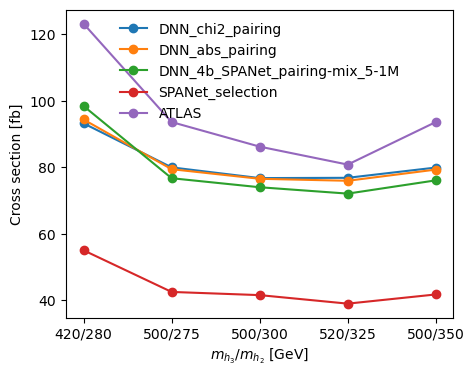

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
for selection_method in ['DNN_chi2_pairing', 'DNN_abs_pairing', 'DNN_4b_SPANet_pairing-mix_5-1M', 'SPANet_selection', 'ATLAS']:
    upper_limits = []
    MG_cross_section = []
    for m3_m2 in m3_m2_list:
        cross_section_s = results[selection_method][m3_m2]['Signal cross section']
        cross_upper_limit = results[selection_method][m3_m2]['Upper limit info']['Expected limits'][2] * cross_section_s
        upper_limits.append(cross_upper_limit)

        MG_cross_section.append(cross_section_s)

    m3_m2_label = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
    ax.plot(m3_m2_label, upper_limits, label=f'{selection_method}', marker='o')

ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Cross section [fb]')
ax.legend(frameon=False)

plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-1M-ATLAS-24_nodes.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()

## 5 mass points mixed: 4b 150k sig + 150k bkg; 6b 10k sig + 50k bkg, 24 nodes x 3

In [5]:
m3_m2_list = [(420, 280), (500, 275), (500, 300), (520, 325), (500, 350)]

In [6]:
results = {}
for pairing_method in ['chi2_pairing', 'abs_pairing', '4b_SPANet_pairing-mix_5-1M']:
    results[f'DNN_{pairing_method}'] = {}
    for m3, m2 in tqdm(m3_m2_list):
        bkg_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/pp6b/bkg-mix_5-150k-24_nodes.npy'
        sig_path = f'./Upper_limit/DNN_selection/{pairing_method}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-150k-24_nodes.npy'
        
        BR_Hbb = 0.5824
        # load csv
        df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
        pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
        pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
        cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
        cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
        cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

        result = {'Signal cross section': cross_section_s,
                  'Background cross section': cross_section_b,
                  'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
                }    

        results[f'DNN_{pairing_method}'][(m3, m2)] = result

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


In [7]:
selection = 'SPANet_selection'
results[selection] = {}
for m3, m2 in tqdm(m3_m2_list):
    bkg_path = f'./Upper_limit/{selection}/TRSM/pp6b/bkg-mix_5-1M.npy'
    sig_path = f'./Upper_limit/{selection}/TRSM/TRSM_{m3}_{m2}/sig-mix_5-1M.npy'
    
    BR_Hbb = 0.5824
    # load csv
    df = pd.read_csv(f'./Sample/selection_efficiencies/TRSM_{m3}_{m2}.csv')
    pass_rate_sig_6b = df[df['Cuts'] == '>= 6 b-jets']['passing rate'].values[0]
    pass_rate_bkg_6b = 0.12 # should be replaced with the actual value
    cross_section_s = get_cross_section_from_MG5(f'Sample/MG5/TRSM_{m3}_{m2}/Events/run_01/run_01_tag_1_banner.txt')
    cross_section_b = get_cross_section_from_MG5('Sample/MG5/pp6b/Events/run_01/run_01_tag_1_banner.txt')
    cross_section = {'signal': cross_section_s * BR_Hbb**3 * pass_rate_sig_6b, 'background': cross_section_b * pass_rate_bkg_6b}

    result = {'Signal cross section': cross_section_s,
                'Background cross section': cross_section_b,
                'Upper limit info': get_upperlimit_info(bkg_path, sig_path, n_bin, hist_range, L, cross_section)
            }    

    results[selection][(m3, m2)] = result

100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


In [8]:
ATLAS_upper_limit = {(420, 280): 123.2, (500, 275): 93.6, (500, 300): 86.2, (520, 325): 80.8, (500, 350): 93.6}
ATLAS_cross_section_s = {(420, 280): 58.9, (500, 275): 52.94, (500, 300): 51.68, (520, 325): 43.78, (500, 350): 37.91}
results['ATLAS'] = {}
for m3_m2 in m3_m2_list:
    result = {'Signal cross section': ATLAS_cross_section_s[m3_m2],
              'Background cross section': 1,
              'Upper limit info': {'Expected limits': [1, 1, ATLAS_upper_limit[m3_m2] / ATLAS_cross_section_s[m3_m2], 1, 1]}
            }
    results['ATLAS'][m3_m2] = result

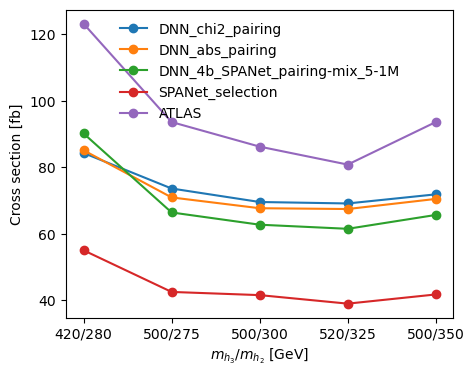

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))
for selection_method in ['DNN_chi2_pairing', 'DNN_abs_pairing', 'DNN_4b_SPANet_pairing-mix_5-1M', 'SPANet_selection', 'ATLAS']:
    upper_limits = []
    MG_cross_section = []
    for m3_m2 in m3_m2_list:
        cross_section_s = results[selection_method][m3_m2]['Signal cross section']
        cross_upper_limit = results[selection_method][m3_m2]['Upper limit info']['Expected limits'][2] * cross_section_s
        upper_limits.append(cross_upper_limit)

        MG_cross_section.append(cross_section_s)

    m3_m2_label = [f'{m3}/{m2}' for m3, m2 in m3_m2_list]
    ax.plot(m3_m2_label, upper_limits, label=f'{selection_method}', marker='o')

ax.set_xlabel('$m_{h_3}/m_{h_2}$ [GeV]')
ax.set_ylabel('Cross section [fb]')
ax.legend(frameon=False)

# plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-1M.pdf', dpi=300, facecolor='White', bbox_inches='tight')
# plt.savefig('./figures/cross_section_upper_limit-TRSM-mix_5-1M-ATLAS.pdf', dpi=300, facecolor='White', bbox_inches='tight')
plt.show()